In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
warnings.filterwarnings("ignore")

In [16]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["axes.labelsize"] = 16
plt.rcParams['axes.titlesize'] = 18

In [4]:
algs = ["Regress out", "BBKNN", "MNN", "Combat", "Scanorama"]

In [5]:
# Number of comparisons is equall 5 * number of dataset * 2 (5 - number of algorithms, 2 - celltype and batch)
n_comps = 5 * 6 * 2
adj_alpha = 0.05 / n_comps

## Here you can see our final results about comparison of diffeterent algorithms which are aimed on batch correction in scRNA data

We used 5 different libraries and 6 (now it is 5) datasets: 3 reall and 3 simulated. All data suffer from batch effect, in generall because of different technologies.

### Read tables with tools performance

In [7]:
# Time performance
time_table = pd.read_csv("../time_performance.csv", index_col=0)

# Silhouette scores
adata1_silhs = pd.read_csv("../adata1/adata1_silhs.csv", index_col=0)
sim_adata1_silhs = pd.read_csv("../simulated_adata1/adata1_silhs.csv", index_col=0)
adata4_silhs = pd.read_csv("../adata4/adata4_silhs.csv", index_col=0)
sim_adata4_silhs = pd.read_csv("../simulated_adata4/adata4_silhs.csv", index_col=0)
adata7_silhs = pd.read_csv("../adata7/adata7_silhs.csv", index_col=0)
sim_adata7_silhs = pd.read_csv("../simulated_adata7/sim_adata7_silhs.csv", index_col=0)

In [8]:
algs_cellt = ["bbknn_bt", "regr_bt", "combat_bt", "scanorama_bt", "mnn_bt"]
algs_title = ["BBKNN", "Regress out", "Combat", "Scanorama", "MNN"]

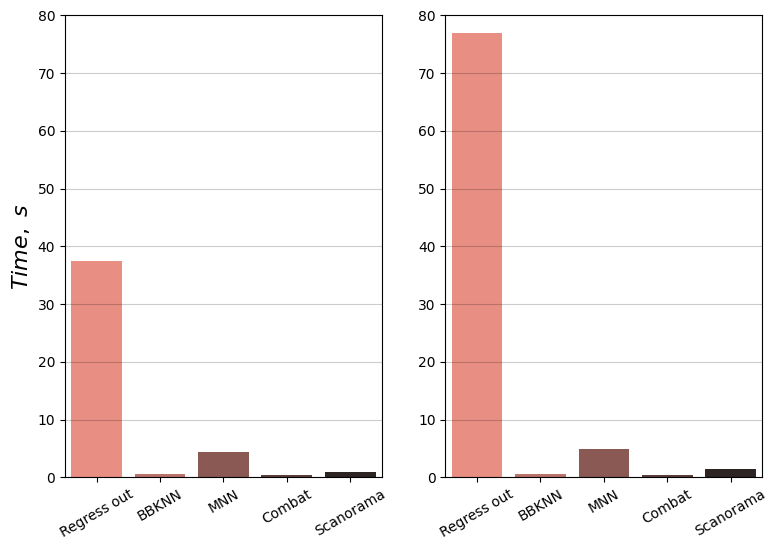

In [18]:
_, axes = plt.subplots(nrows=1, ncols=2)

axes[0].grid(color="black", alpha=0.2)
axes[1].grid(color="black", alpha=0.2)
sns.barplot(y=time_table["reall_500"], x=algs, ax=axes[0], palette="dark:salmon_r")
sns.barplot(y=time_table["simulated_500"], x=algs, ax=axes[1], palette="dark:salmon_r")
axes[0].set_ylabel(r"$Time,\ s$")
axes[1].set_ylabel(r"")
plt.setp(axes, ylim=[0, 80])
axes[0].set_xticklabels(algs, rotation = 30)
axes[1].set_xticklabels(algs, rotation = 30)


plt.savefig("../visualization/small.png", dpi=150, format="png", transparent=True, bbox_inches="tight")

plt.show()

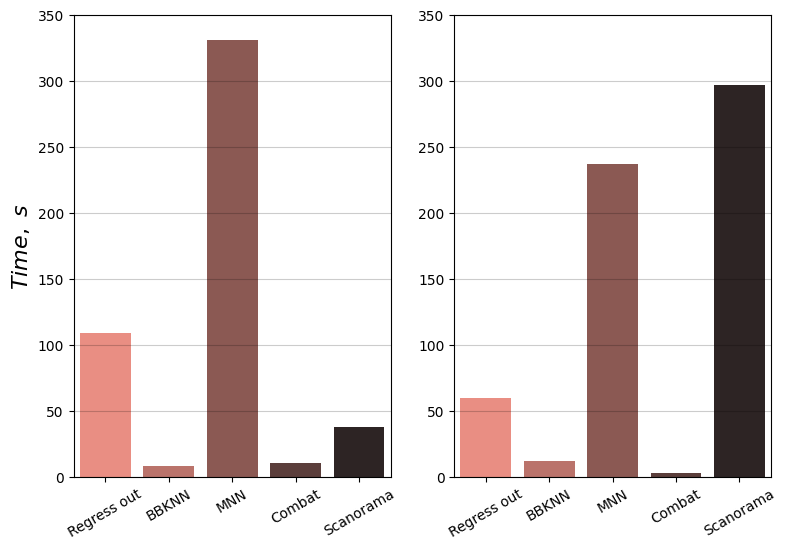

In [19]:
_, axes = plt.subplots(nrows=1, ncols=2)

axes[0].grid(color="black", alpha=0.2)
axes[1].grid(color="black", alpha=0.2)
sns.barplot(y=time_table["reall_15000"], x=algs, ax=axes[0], palette="dark:salmon_r")
sns.barplot(y=time_table["simulated_15000"], x=algs, ax=axes[1], palette="dark:salmon_r")
axes[0].set_ylabel(r"$Time,\ s$")
axes[1].set_ylabel(r"")
plt.setp(axes, ylim=[0, 350])
axes[0].set_xticklabels(algs, rotation = 30)
axes[1].set_xticklabels(algs, rotation = 30)

plt.savefig("../visualization/medium.png", dpi=150, format="png", transparent=True, bbox_inches="tight")

plt.show()

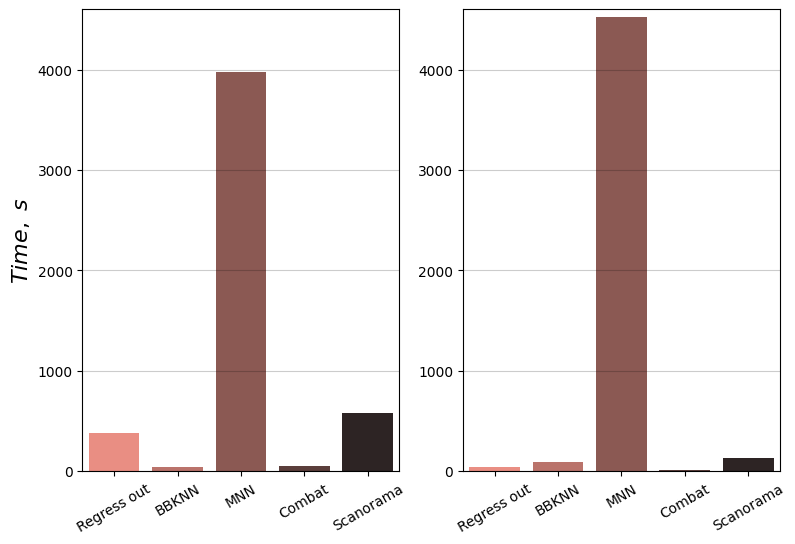

In [20]:
_, axes = plt.subplots(nrows=1, ncols=2)


axes[0].grid(which="major", color="black", alpha=0.2)
axes[1].grid(which="major", color="black", alpha=0.2)
sns.barplot(y=time_table["reall_80000"], x=algs, ax=axes[0], palette="dark:salmon_r")
sns.barplot(y=time_table["simulated_80000"], x=algs, ax=axes[1], palette="dark:salmon_r")
axes[0].set_ylabel(r"$Time,\ s$")
axes[1].set_ylabel(r"")
plt.setp(axes, ylim=[0, 4600])
axes[0].set_xticklabels(algs, rotation = 30)
axes[1].set_xticklabels(algs, rotation = 30)

plt.savefig("../visualization/big.png", dpi=150, format="png", transparent=True, bbox_inches="tight")

plt.show()

In [35]:
time_table["reall_500"]
algs

['Regress out', 'BBKNN', 'MNN', 'Combat', 'Scanorama']

In [27]:
def plot_result(adata_silhs, algs_title, p_values, times, xlim=[None, None], by="celltype"):
    """
    Plot histograms to compare algormthms and baseline and also plot bar of time performance
    """
    if by=="celltype":
        base = "base_bt"
        algs_cellt = ["bbknn_bt", "regr_bt", "combat_bt", "scanorama_bt", "mnn_bt"]
    elif by=="batch":
        base = "base_bt_b"
        algs_cellt = ["bbknn_bt_b", "regr_bt_b", "combat_bt_b", "scanorama_bt_b", "mnn_bt_b"]
    
    fig, axes = plt.subplots(nrows=2, ncols=3)
    coords = [[0, 0], [0, 1], [0, 2],
              [1, 0], [1, 1], [1, 2]]
    #plt.xlim(xlim)
    plt.setp(axes, xlim=xlim)
    for al, ax, alg, p_val in zip(algs_title, coords[:-1], algs_cellt, p_values):
        axes[ax[0], ax[1]].grid(which="major", color="black", alpha=0.2)
        sns.histplot(adata_silhs[base], color="#7B98AD", stat="probability", alpha=0.5, ax=axes[ax[0], ax[1]])
        sns.histplot(adata_silhs[alg], color="#DCAD80", stat="probability", alpha=0.5, ax=axes[ax[0], ax[1]])
        axes[ax[0], ax[1]].set_xlabel(r"$Silhouette_{cell-type}$")
        axes[ax[0], ax[1]].set_ylabel(r"")
        axes[ax[0], ax[1]].tick_params(labelsize=15)
        if p_val <= adj_alpha:
            axes[ax[0], ax[1]].set_title(f"{al} $_{{p-value = {p_val}}}*$")
        else:
            axes[ax[0], ax[1]].set_title(f"{al} $_{{p-value = {p_val}}}$")

    axes[0, 0].set_ylabel(r"$Probability\ density$")
    axes[1, 0].set_ylabel(r"$Probability\ density$")

    axes[1, 2].grid(which="major", color="black", alpha=0.2)
    sns.barplot(y=times, x=algs, ax=axes[1, 2], palette="dark:salmon_r")
    axes[1, 2].set_ylabel(r"$Time,\ s$")


    plt.show()
    
    
def calculate_p_val(adata_silhs, by="celltype"):
    """
    Calculate p-value for baseline and algorithm comparison by MU method
    """
    if by=="celltype":
        alt = "less"
        base = "base_bt"
        algs_cellt = ["bbknn_bt", "regr_bt", "combat_bt", "scanorama_bt", "mnn_bt"]
    elif by=="batch":
        alt = "greater"
        base = "base_bt_b"
        algs_cellt = ["bbknn_bt_b", "regr_bt_b", "combat_bt_b", "scanorama_bt_b", "mnn_bt_b"]
        
    adata_p = []
    for alg in algs_cellt:
        adata_p.append(round(mannwhitneyu(adata_silhs[base], adata_silhs[alg], alternative=alt).pvalue, 4))
        
    adata1_p = pd.DataFrame({"p-value": adata_p}, index=algs_cellt)
    return adata1_p


def make_long_adata(adata_silhs):
    """
    Make long format data from adata_silhs table
    """
    long_adata = {
    "silhouette": [],
    "label": [],
    "method": []
    }

    length = len(adata_silhs)

    for col in adata_silhs.columns.values:
        long_adata["silhouette"] += list(adata_silhs[col].values)
        long_adata["method"] += [col.split("_")[0]] * length
        if col[-1] == "b":
            long_adata["label"] += ["Batch"] * length
        else:
            long_adata["label"] += ["Cell-type"] * length

    long_adata = pd.DataFrame(long_adata)
    
    return long_adata

### Plot silhouette performance baseline vs algorithms and also time comparison

### NB! On all histograms blue = baseline, yellow = corrected by folowwing algorithm. (It will be depicted on finall presenration)

### Adata1

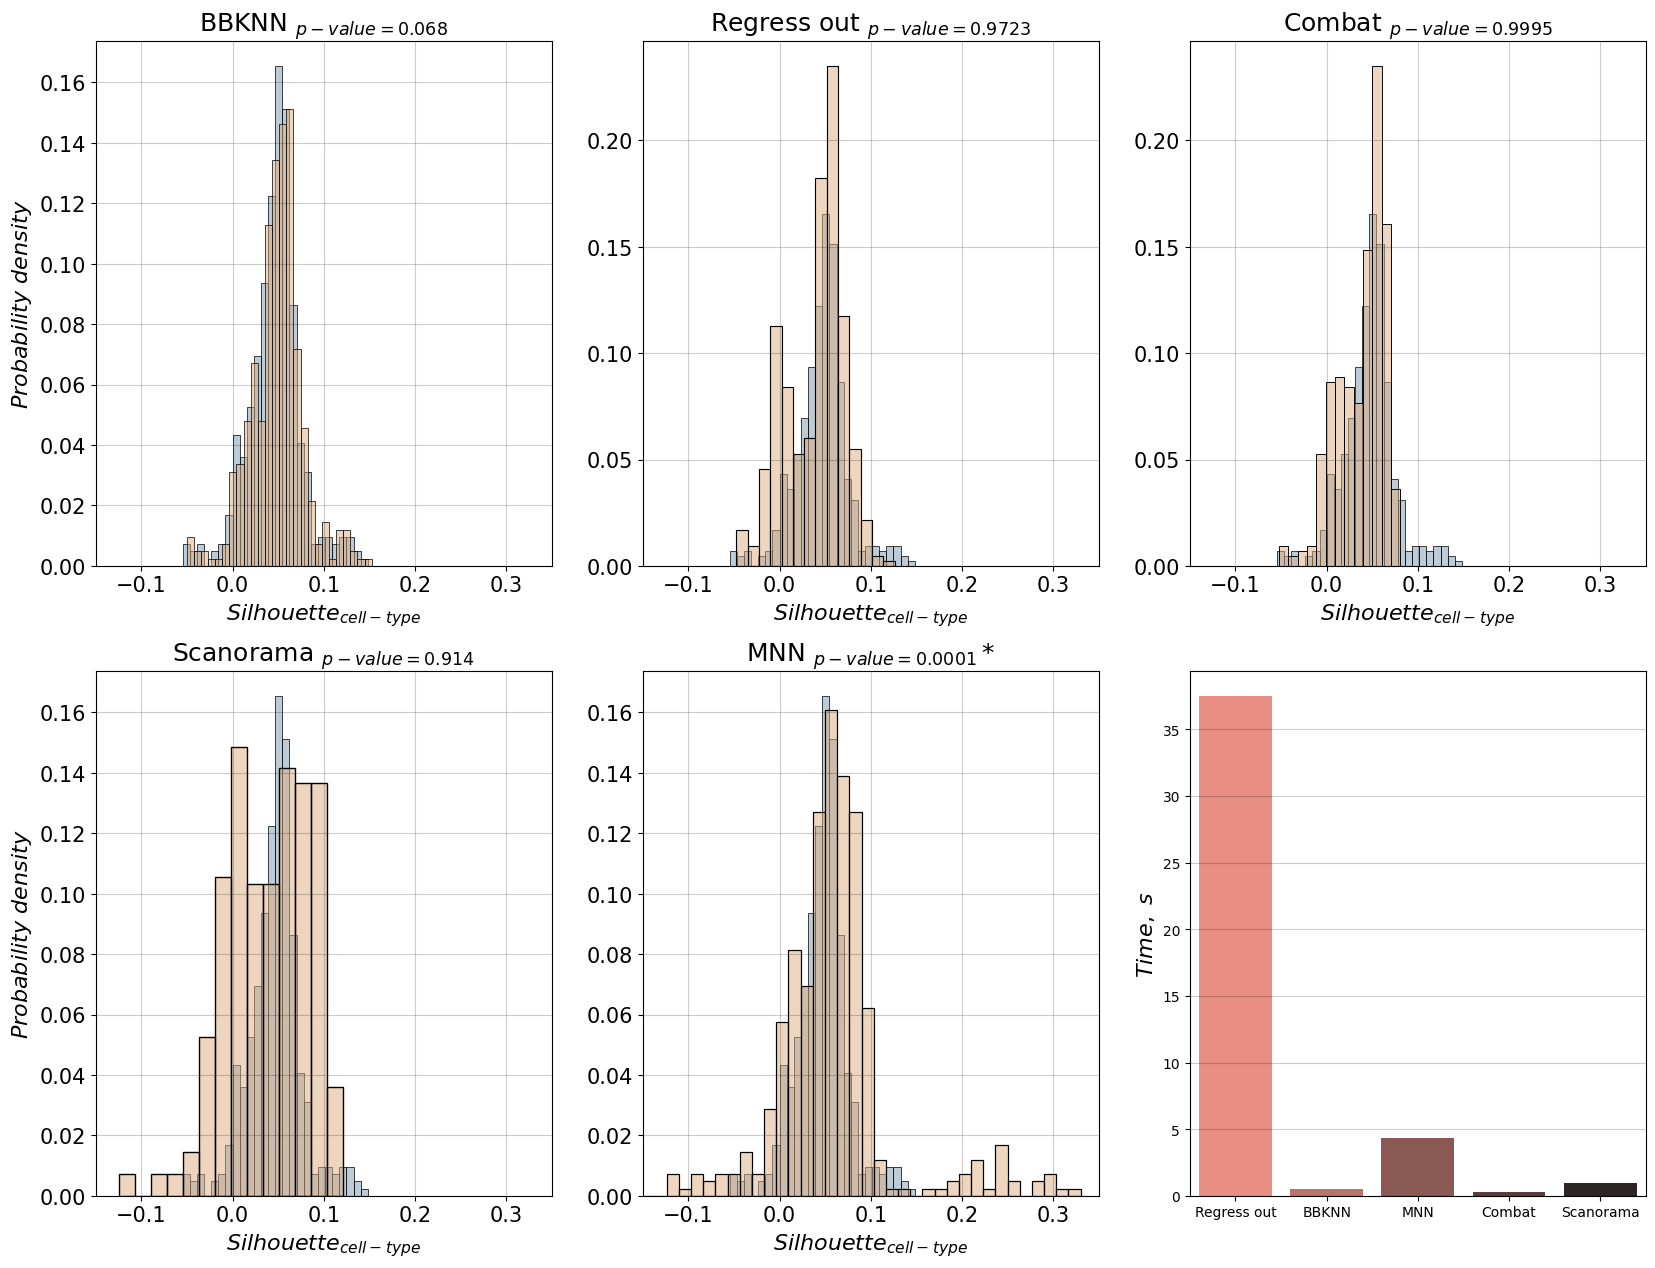

In [28]:
# Silhs based on cell type
plot_result(adata1_silhs, algs_title, calculate_p_val(adata1_silhs, by="celltype")["p-value"], time_table["reall_500"], xlim=[-0.15, 0.35])

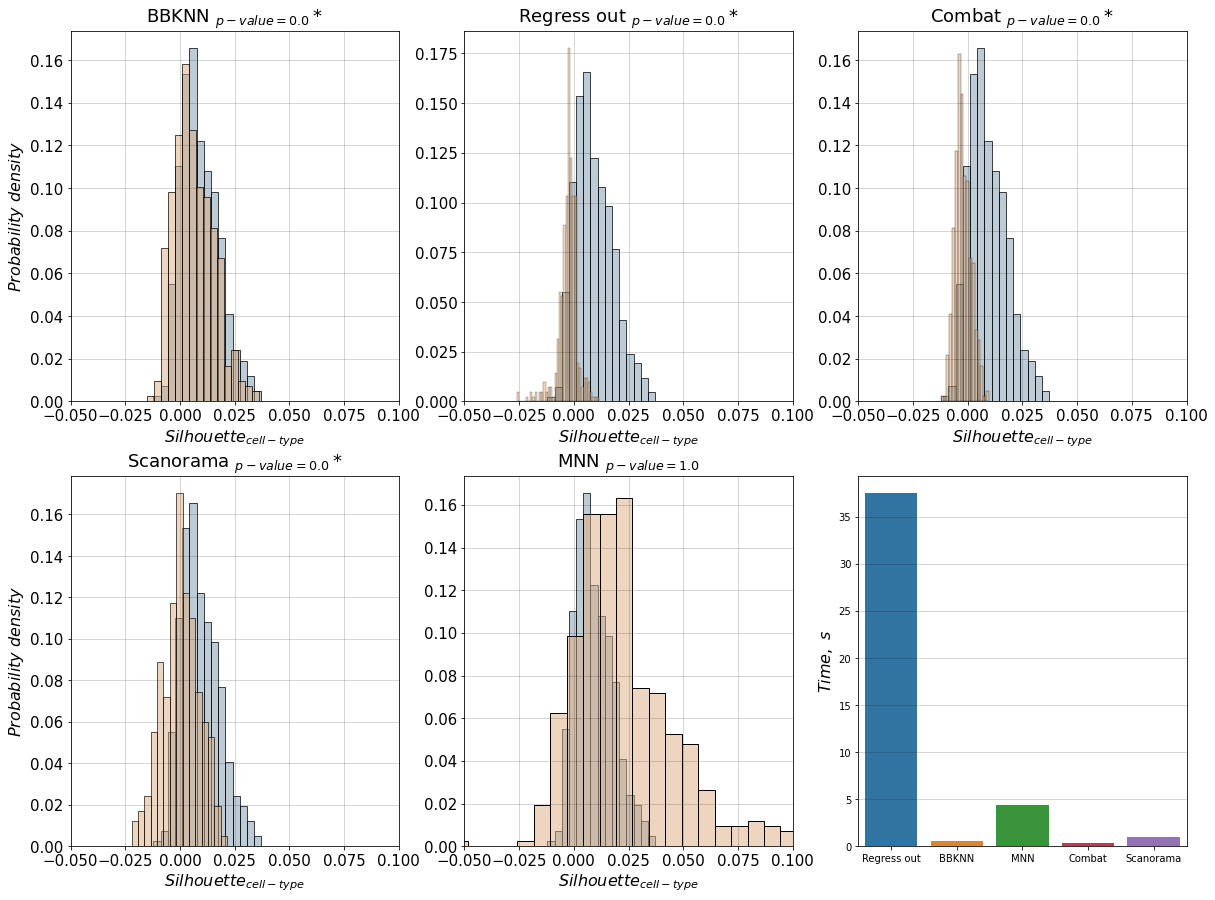

In [22]:
# Silhs based on batch
plot_result(adata1_silhs, algs_title, calculate_p_val(adata1_silhs, by="batch")["p-value"], time_table["reall_500"], by="batch", xlim=[-0.05, 0.1])

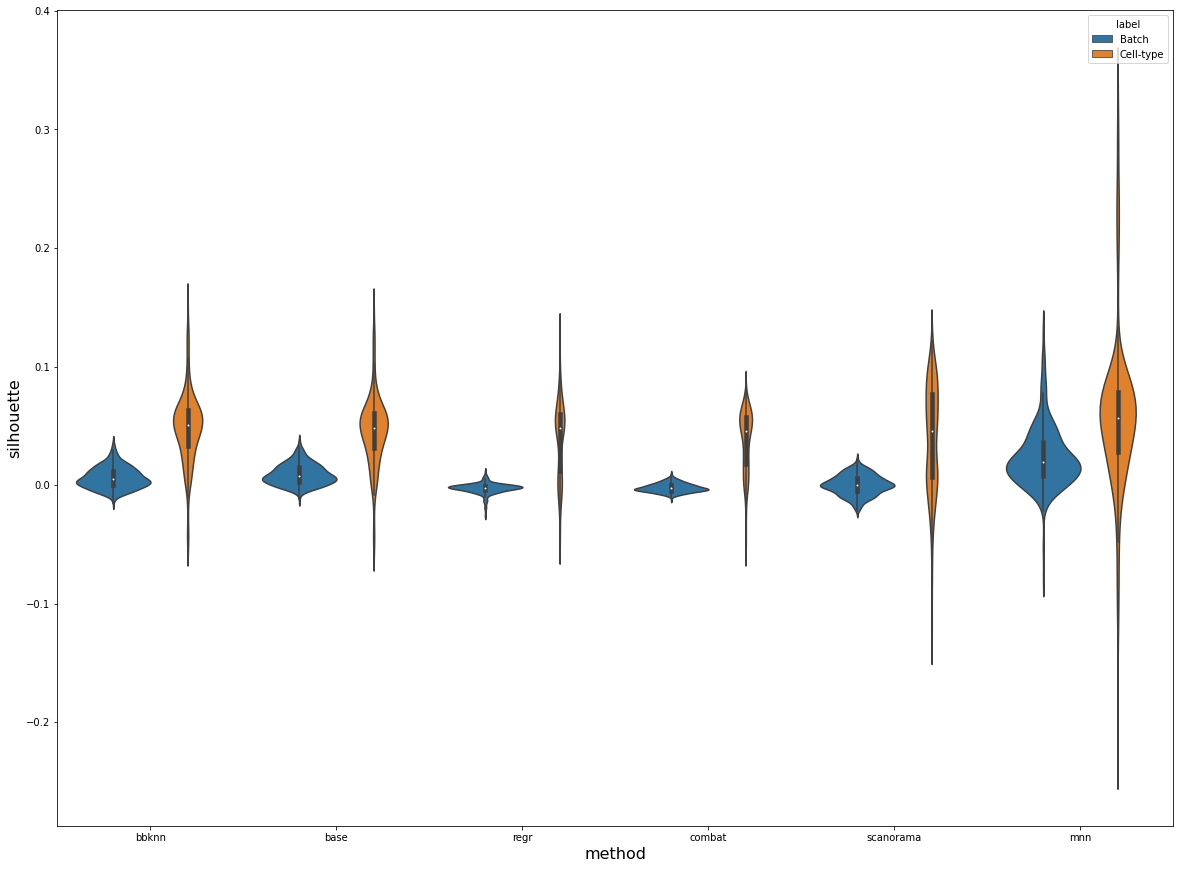

In [45]:
sns.violinplot(data=make_long_adata(adata1_silhs), x="method", y="silhouette", hue="label")
plt.show()

### Simulated Adata1

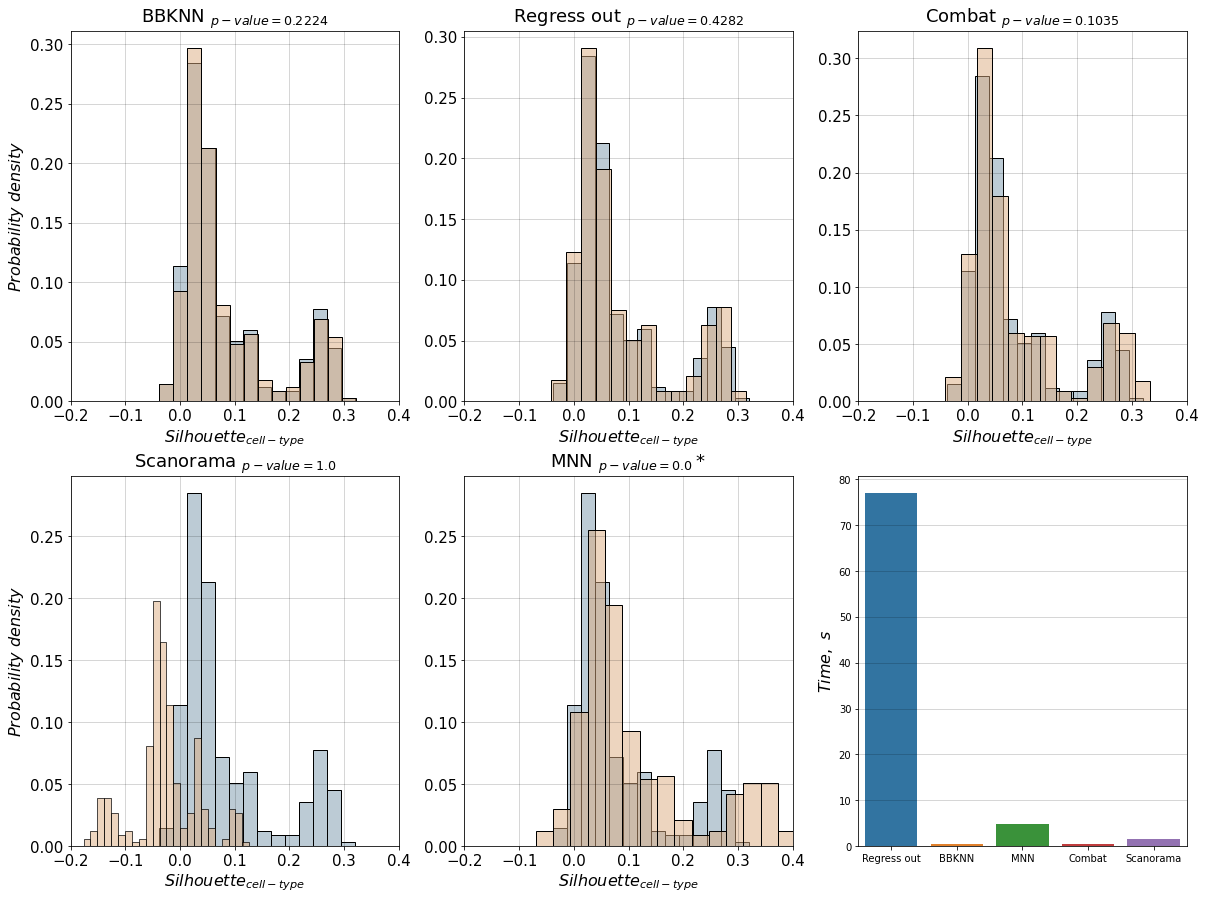

In [24]:
# Silhs based on cell type
plot_result(sim_adata1_silhs, algs_title, calculate_p_val(sim_adata1_silhs, by="celltype")["p-value"], time_table["simulated_500"], xlim=[-0.2, 0.4])

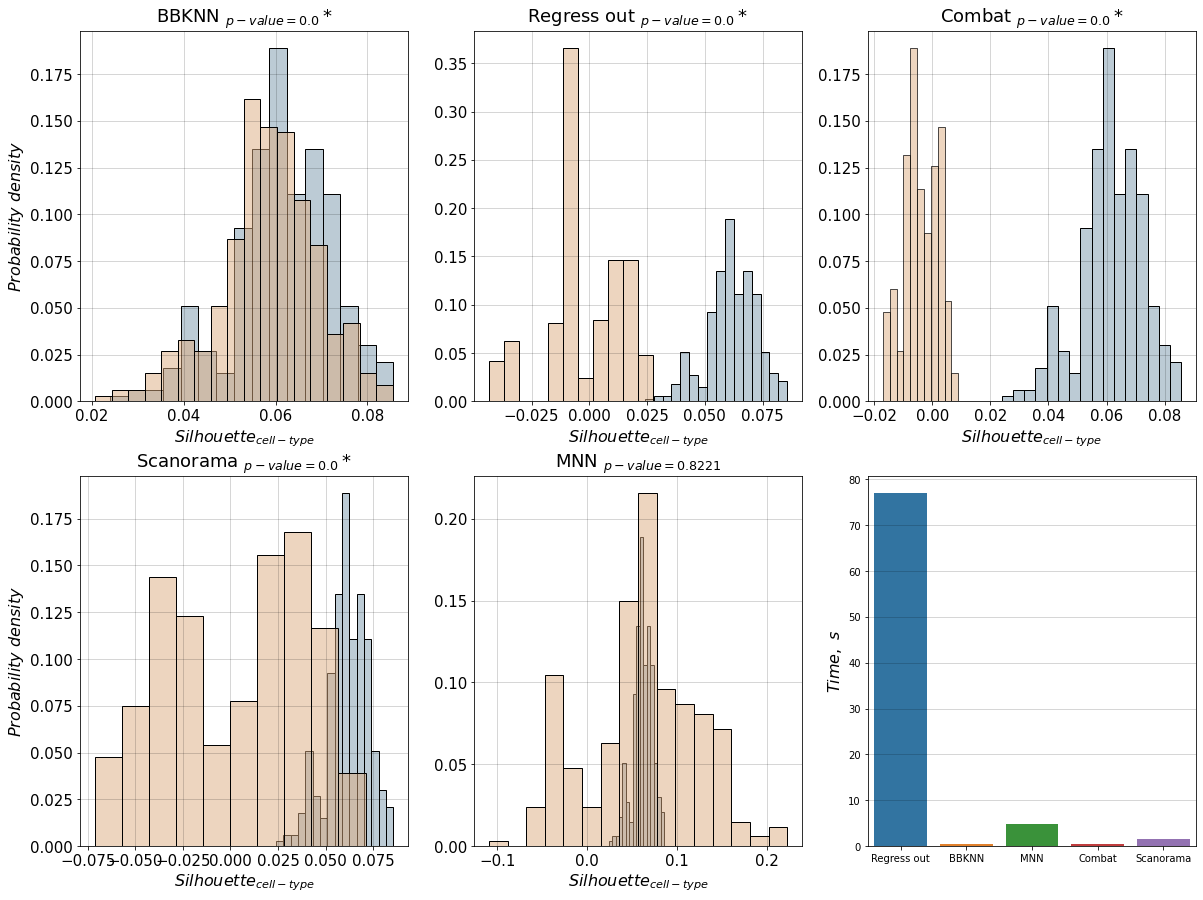

In [134]:
# Silhs based on batch
plot_result(sim_adata1_silhs, algs_title, calculate_p_val(sim_adata1_silhs, by="batch")["p-value"], time_table["simulated_500"], by="batch")

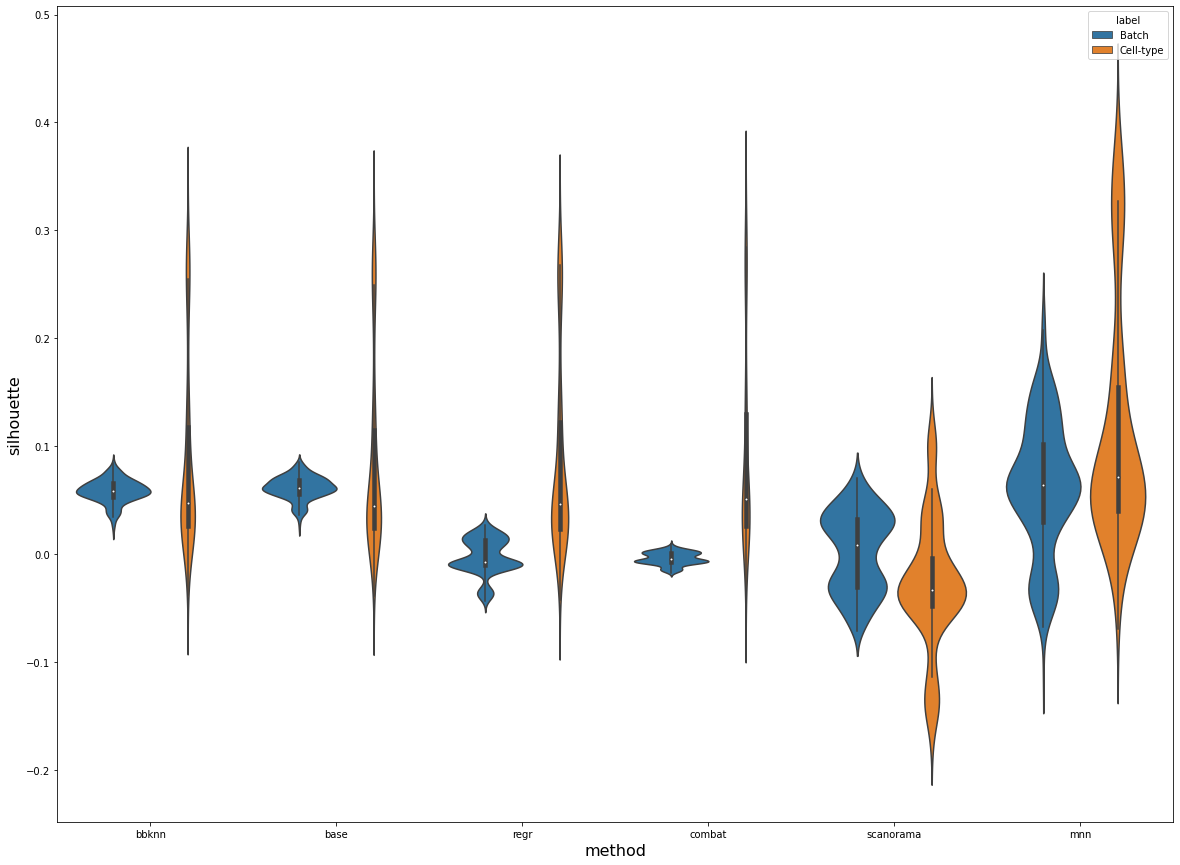

In [46]:
sns.violinplot(data=make_long_adata(sim_adata1_silhs), x="method", y="silhouette", hue="label")
plt.show()

### Adata4

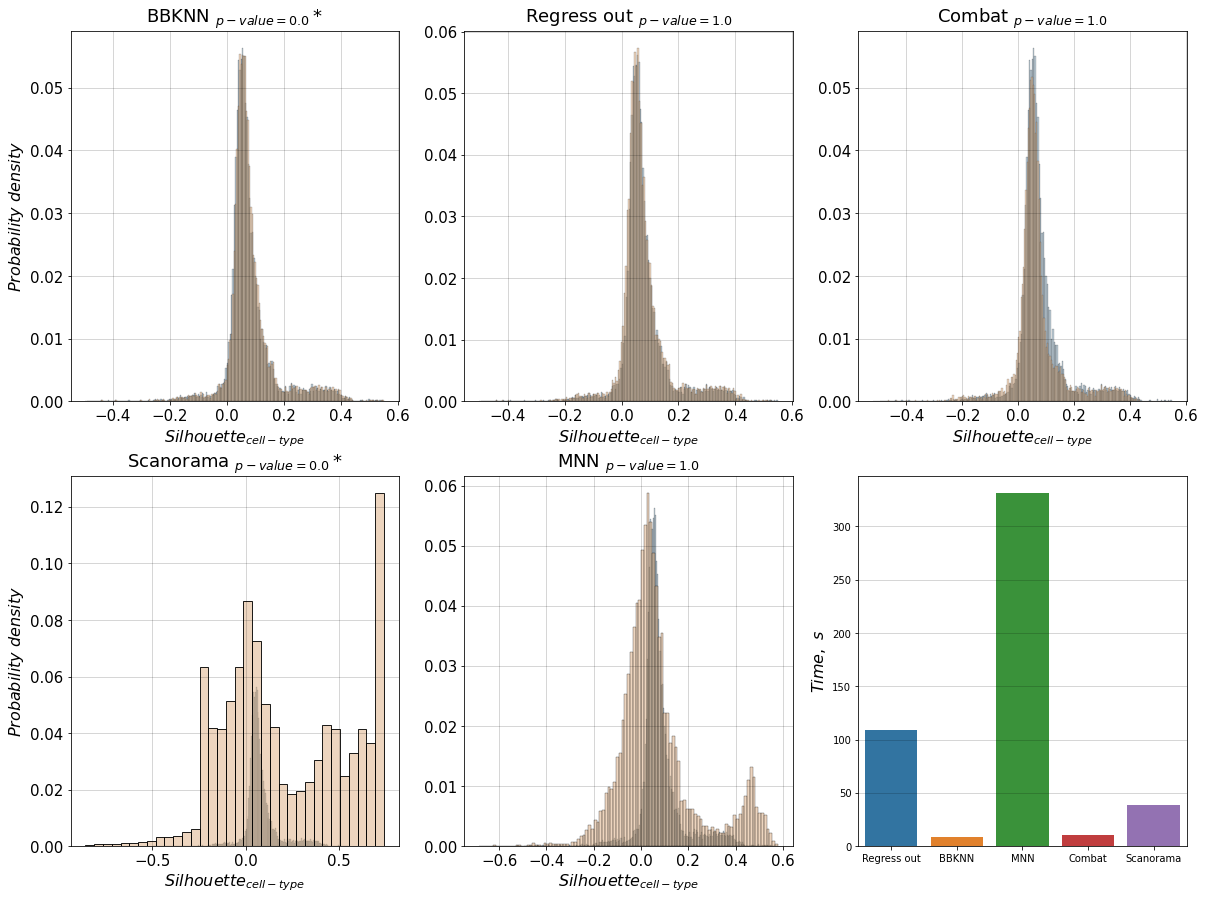

In [136]:
# Silhs based on cell type
plot_result(adata4_silhs, algs_title, calculate_p_val(adata4_silhs, by="celltype")["p-value"], time_table["reall_15000"])

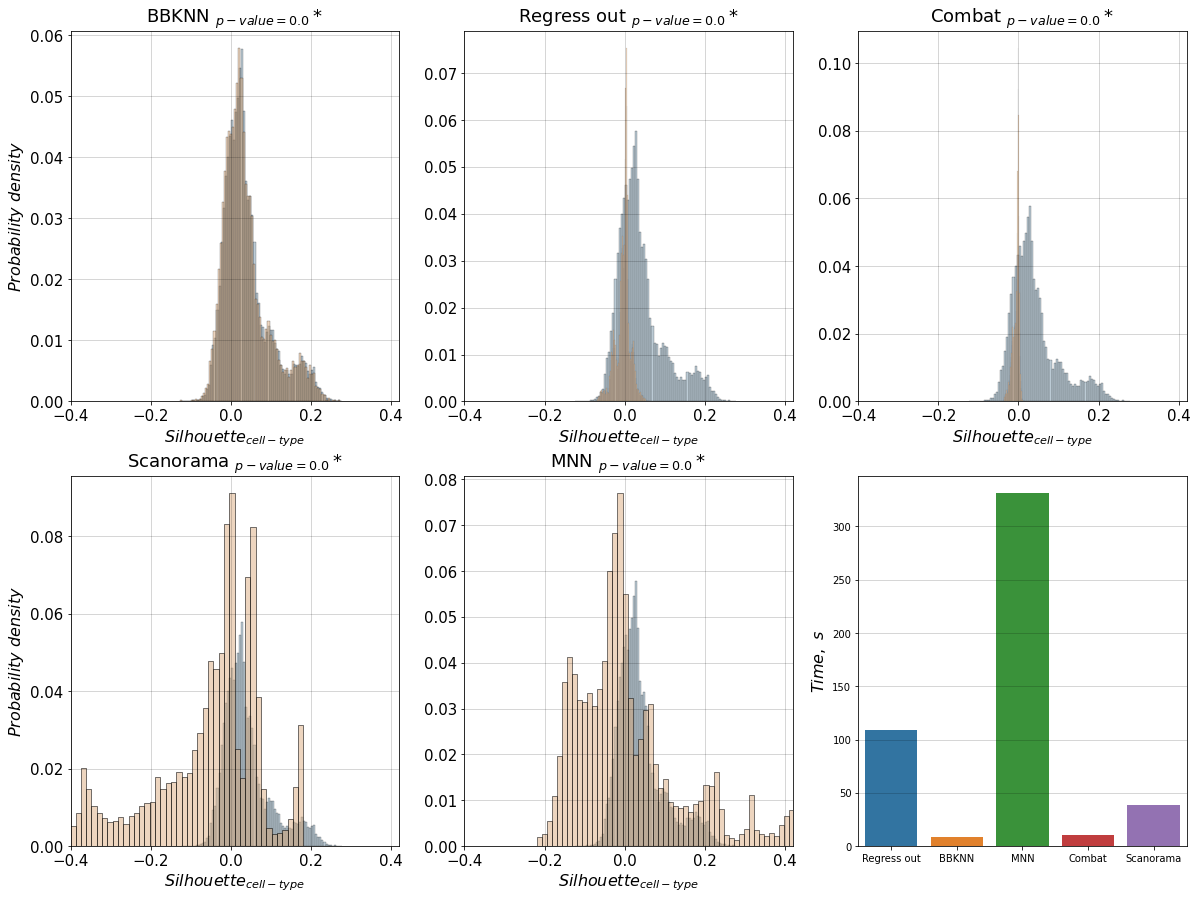

In [25]:
# Silhs based on batch
plot_result(adata4_silhs, algs_title, calculate_p_val(adata4_silhs, by="batch")["p-value"], time_table["reall_15000"], by="batch", xlim=[-0.4, 0.42])

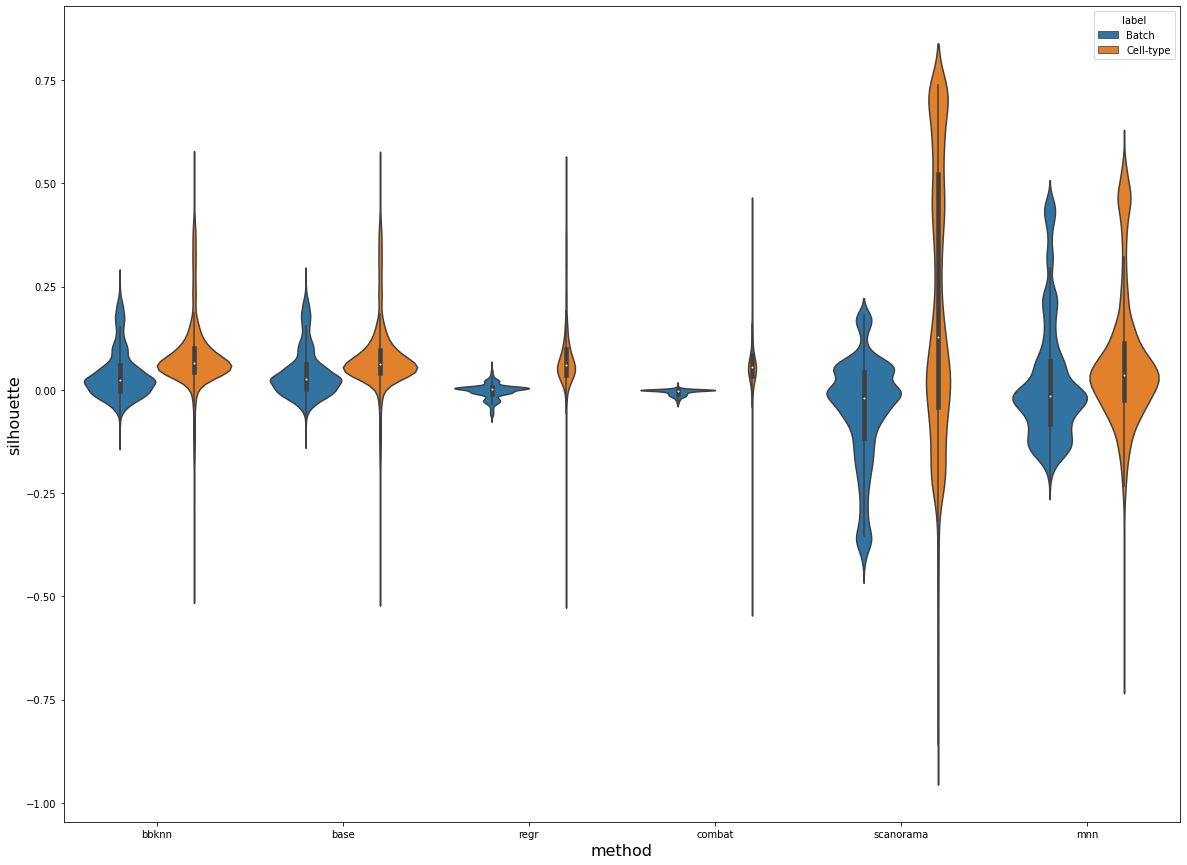

In [47]:
sns.violinplot(data=make_long_adata(adata4_silhs), x="method", y="silhouette", hue="label")
plt.show()

### Simulated Adata4

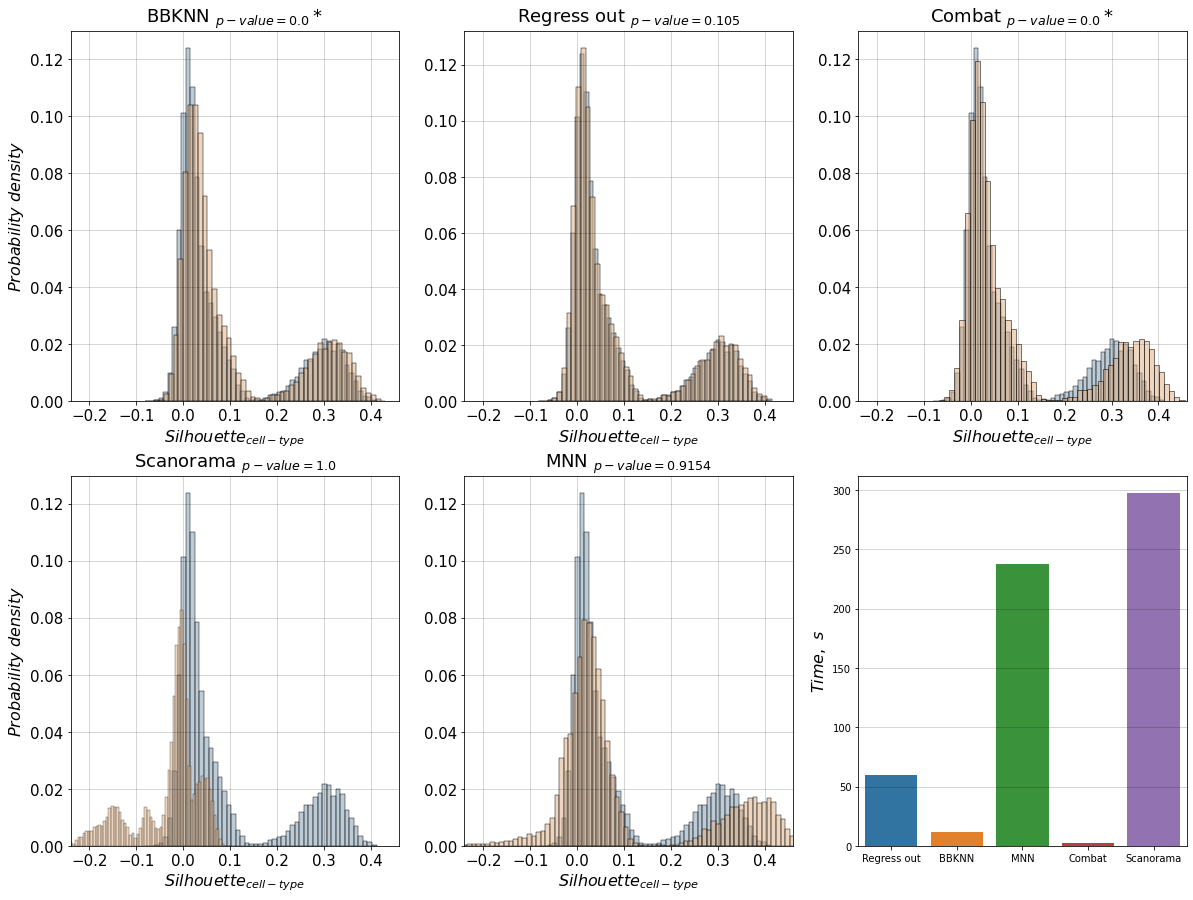

In [28]:
# Silhs based on cell type
plot_result(sim_adata4_silhs, algs_title, calculate_p_val(sim_adata4_silhs, by="celltype")["p-value"], time_table["simulated_15000"], xlim=[-0.24, 0.46])

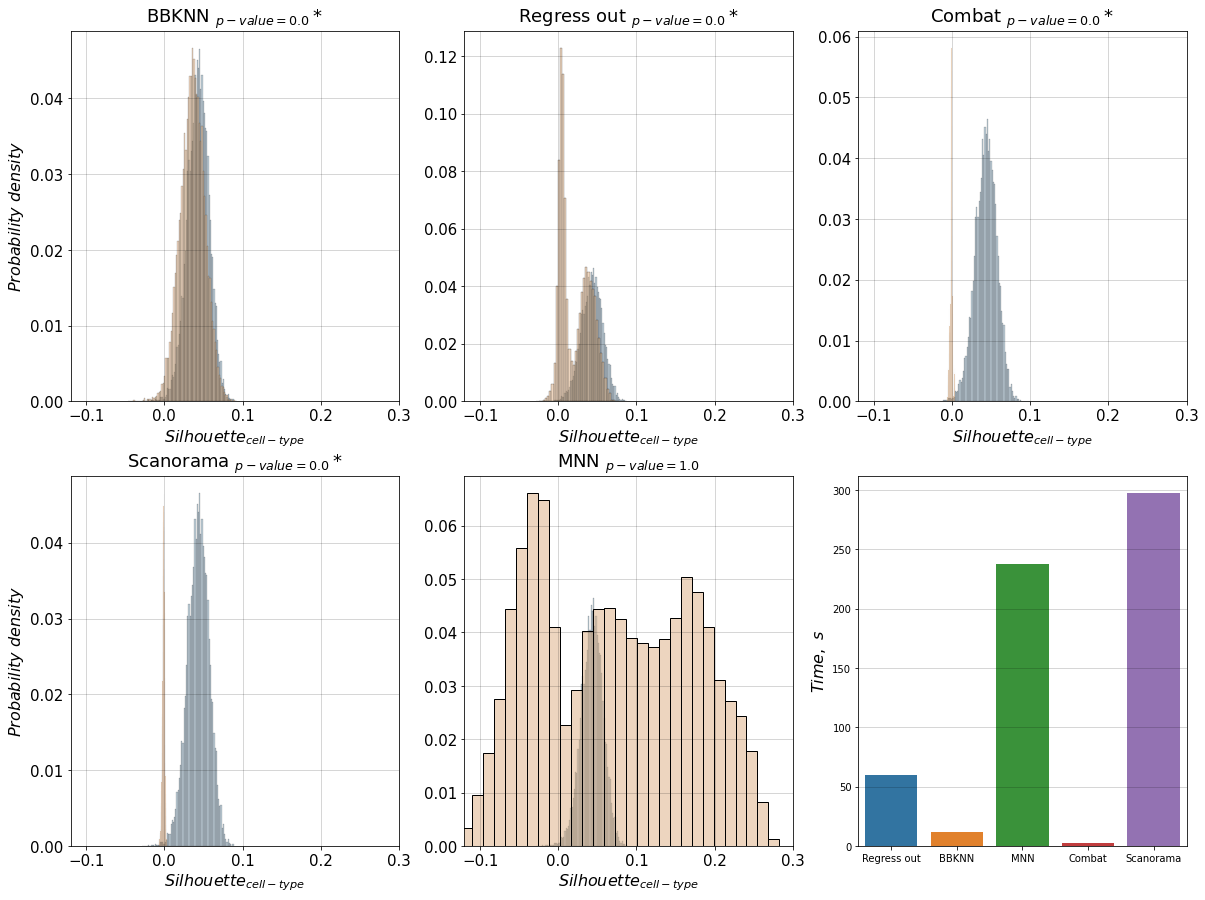

In [29]:
# Silhs based on batch
plot_result(sim_adata4_silhs, algs_title, calculate_p_val(sim_adata4_silhs, by="batch")["p-value"], time_table["simulated_15000"], by="batch", xlim=[-0.12, 0.3])

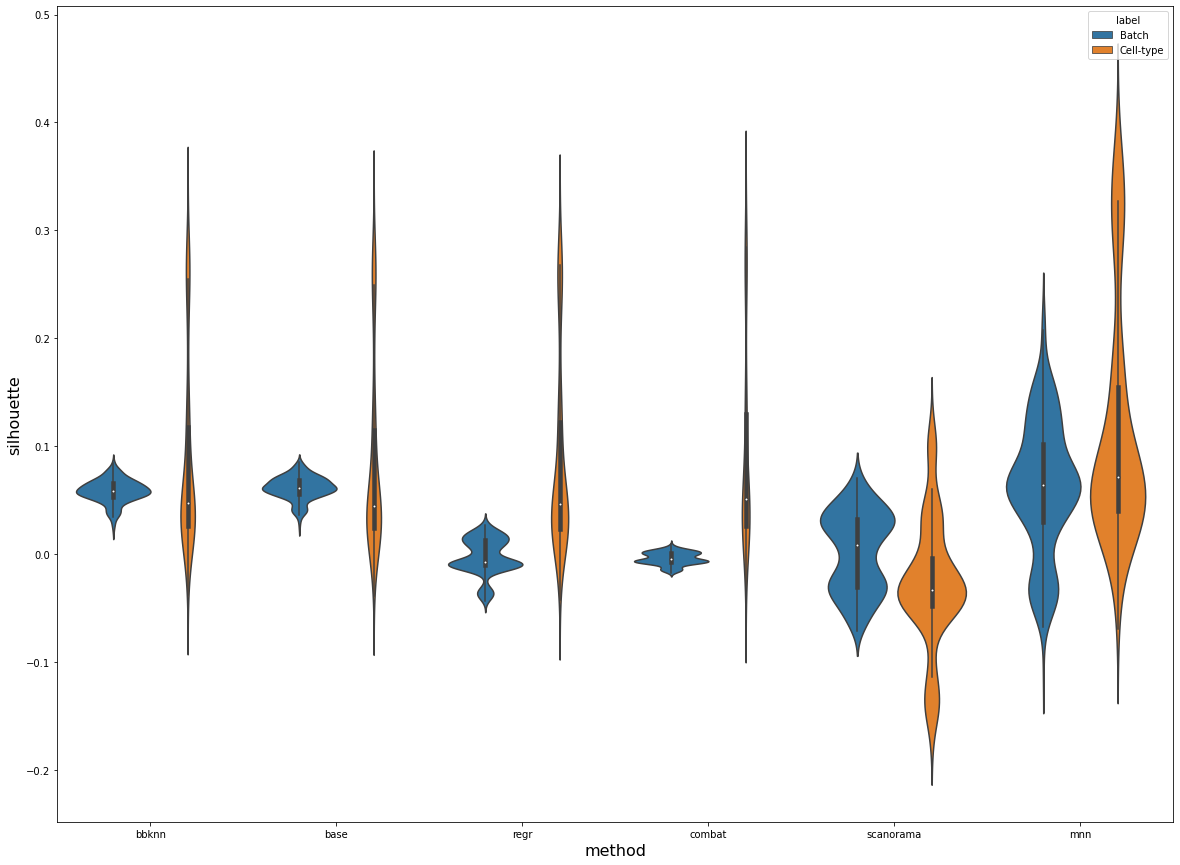

In [48]:
sns.violinplot(data=make_long_adata(sim_adata1_silhs), x="method", y="silhouette", hue="label")
plt.show()

### Adata7

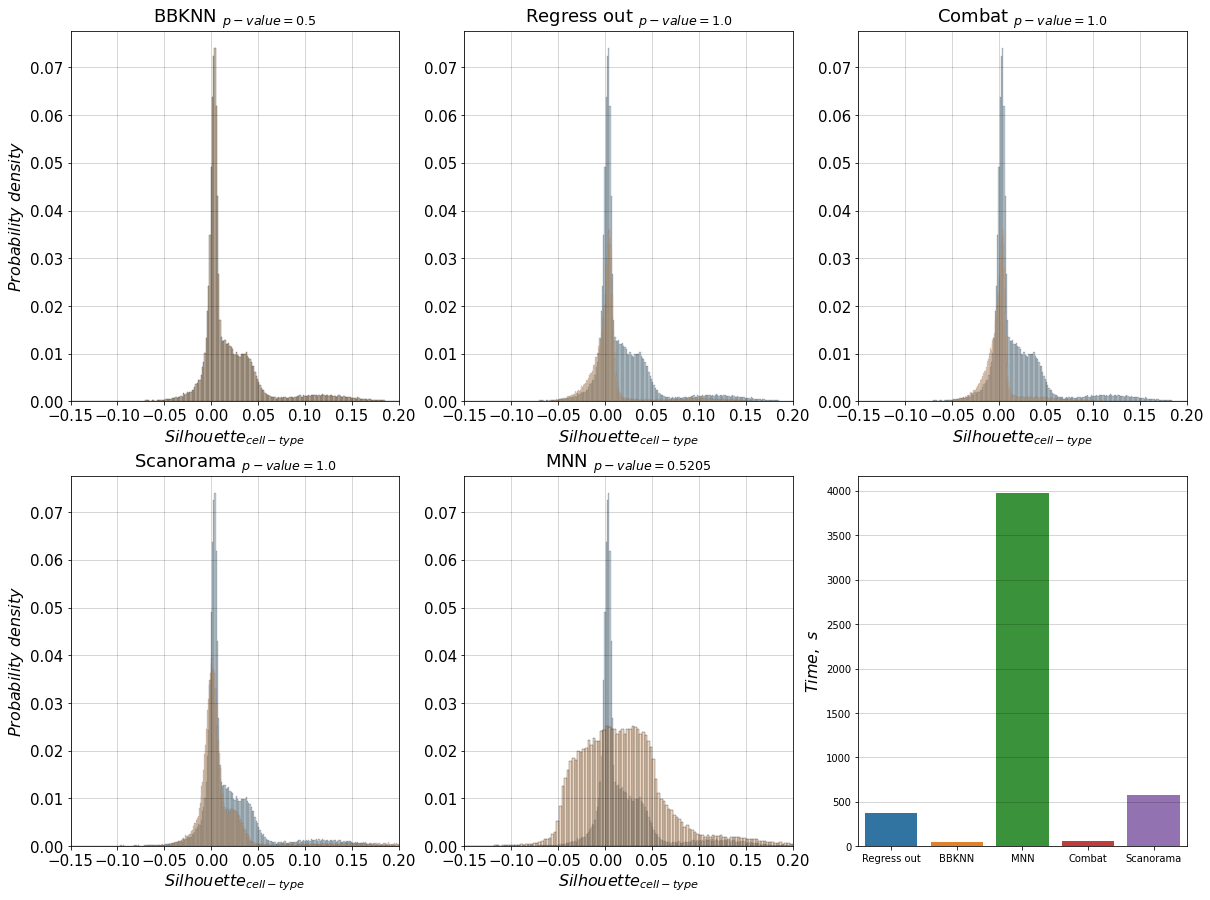

In [31]:
# Silhs based on cell type
plot_result(adata7_silhs, algs_title, calculate_p_val(adata7_silhs, by="celltype")["p-value"], time_table["reall_80000"], xlim=[-0.15, 0.2])

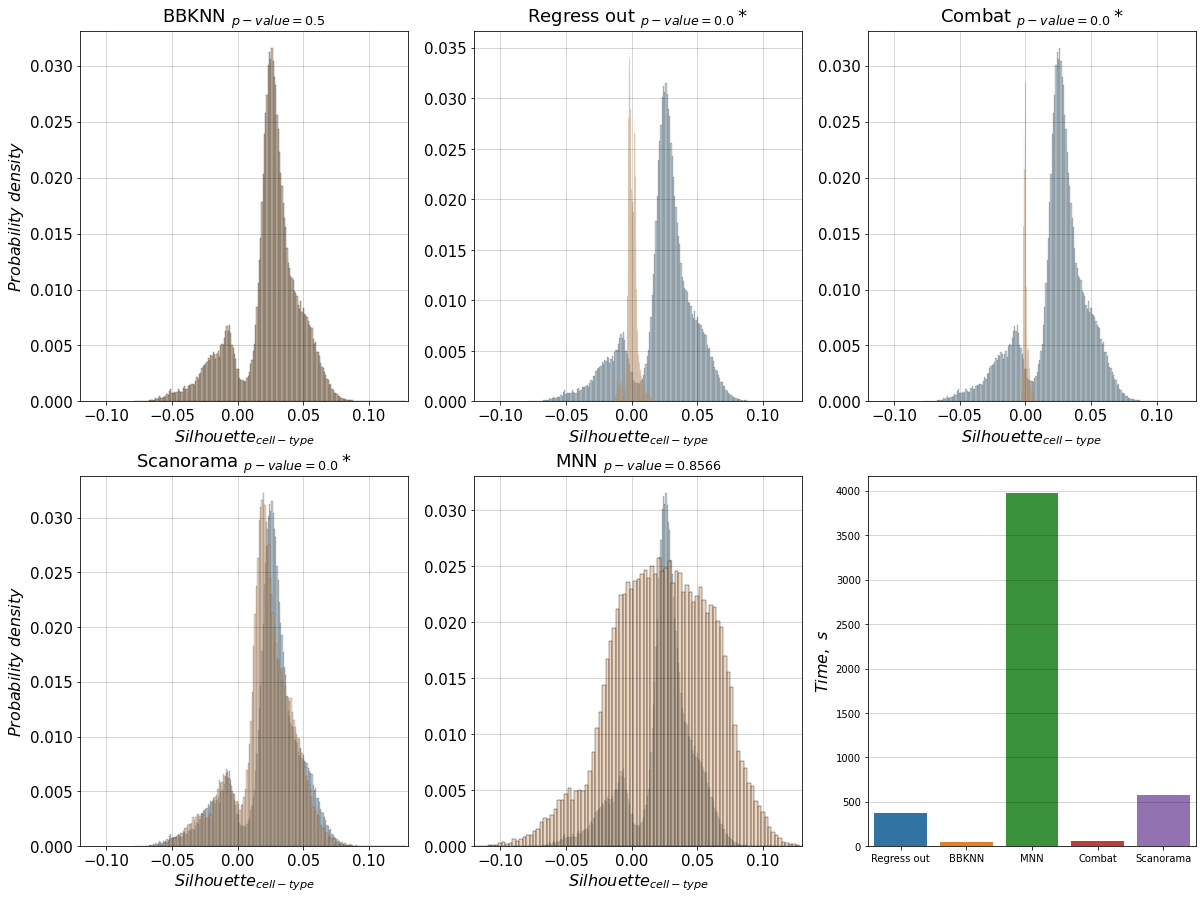

In [32]:
# Silhs based on batch
plot_result(adata7_silhs, algs_title, calculate_p_val(adata7_silhs, by="batch")["p-value"], time_table["reall_80000"], by="batch", xlim=[-0.12, 0.13])

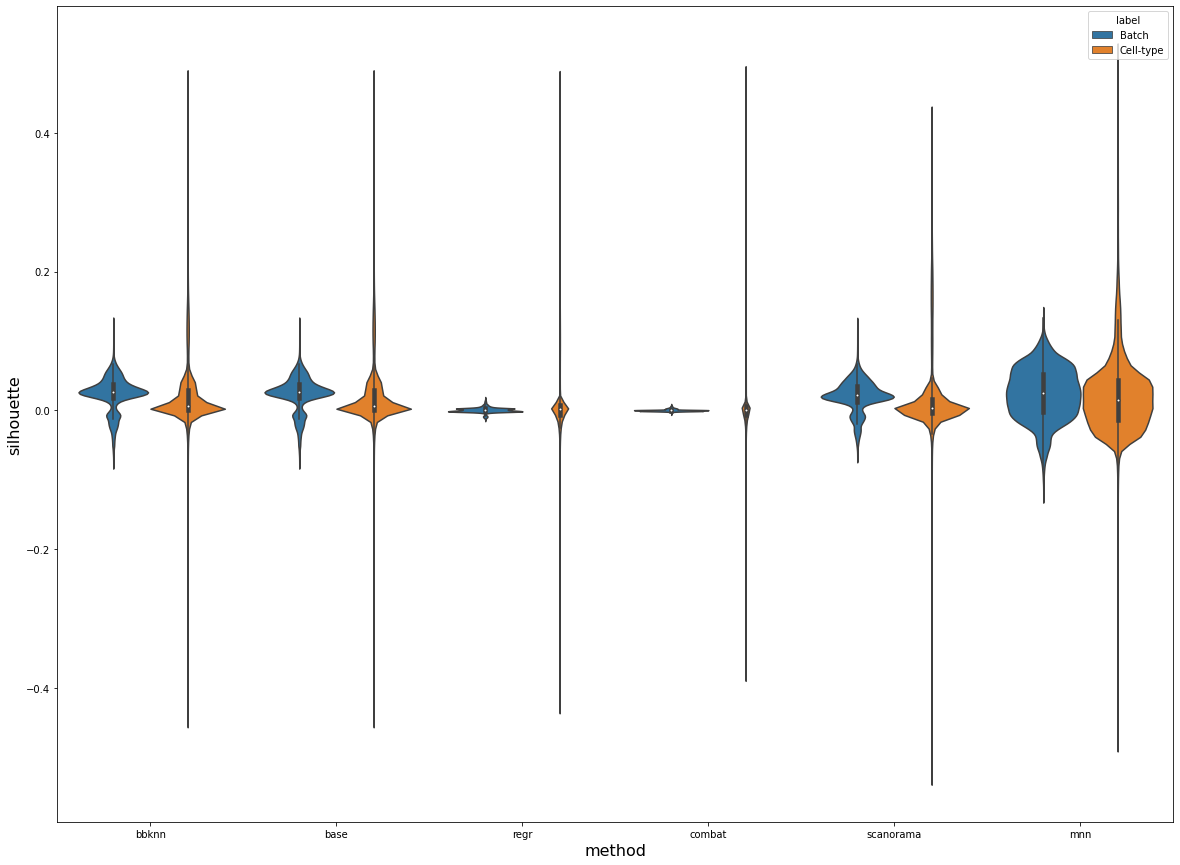

In [49]:
sns.violinplot(data=make_long_adata(adata7_silhs), x="method", y="silhouette", hue="label")
plt.show()

### Simulated Adata7

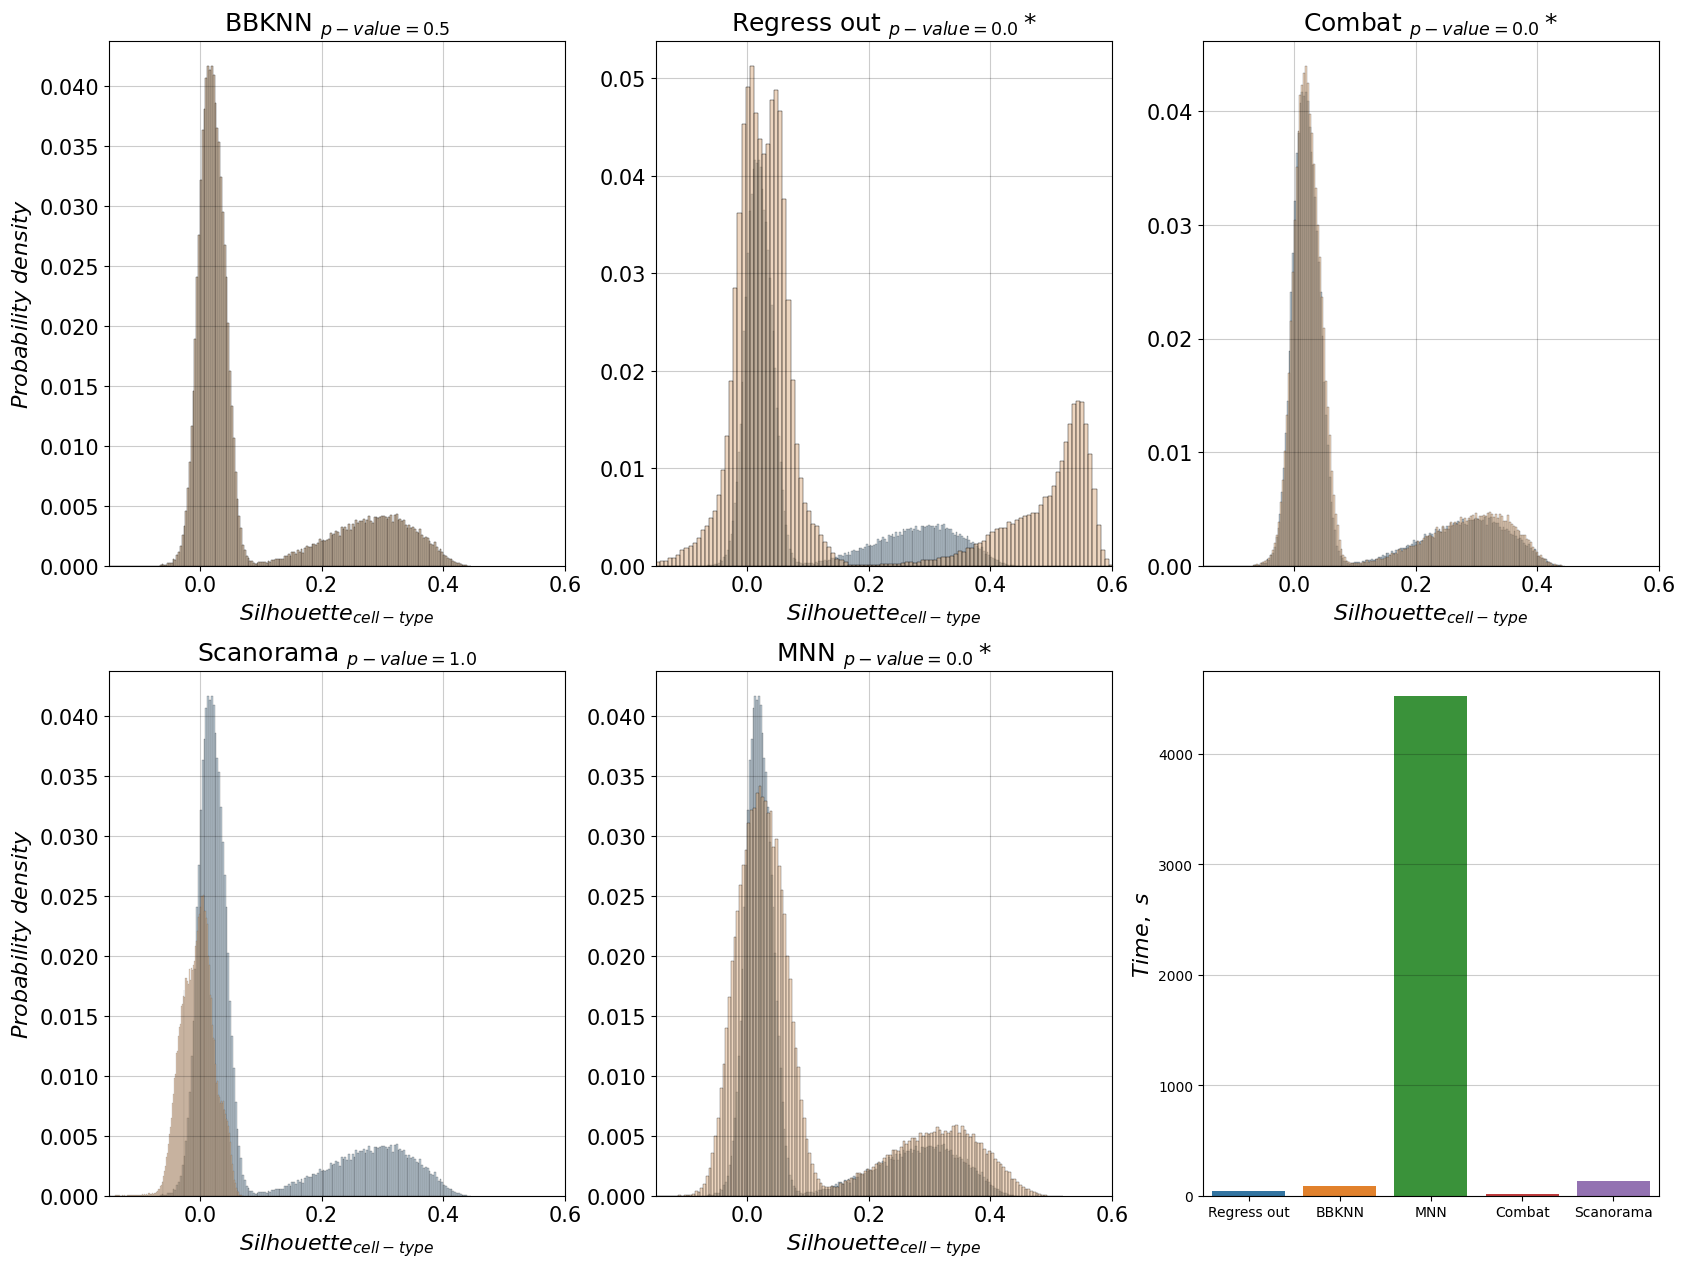

In [17]:
# Silhs based on cell type
plot_result(sim_adata7_silhs, algs_title, calculate_p_val(sim_adata7_silhs, by="celltype")["p-value"], time_table["simulated_80000"], xlim=[-0.15, 0.6])

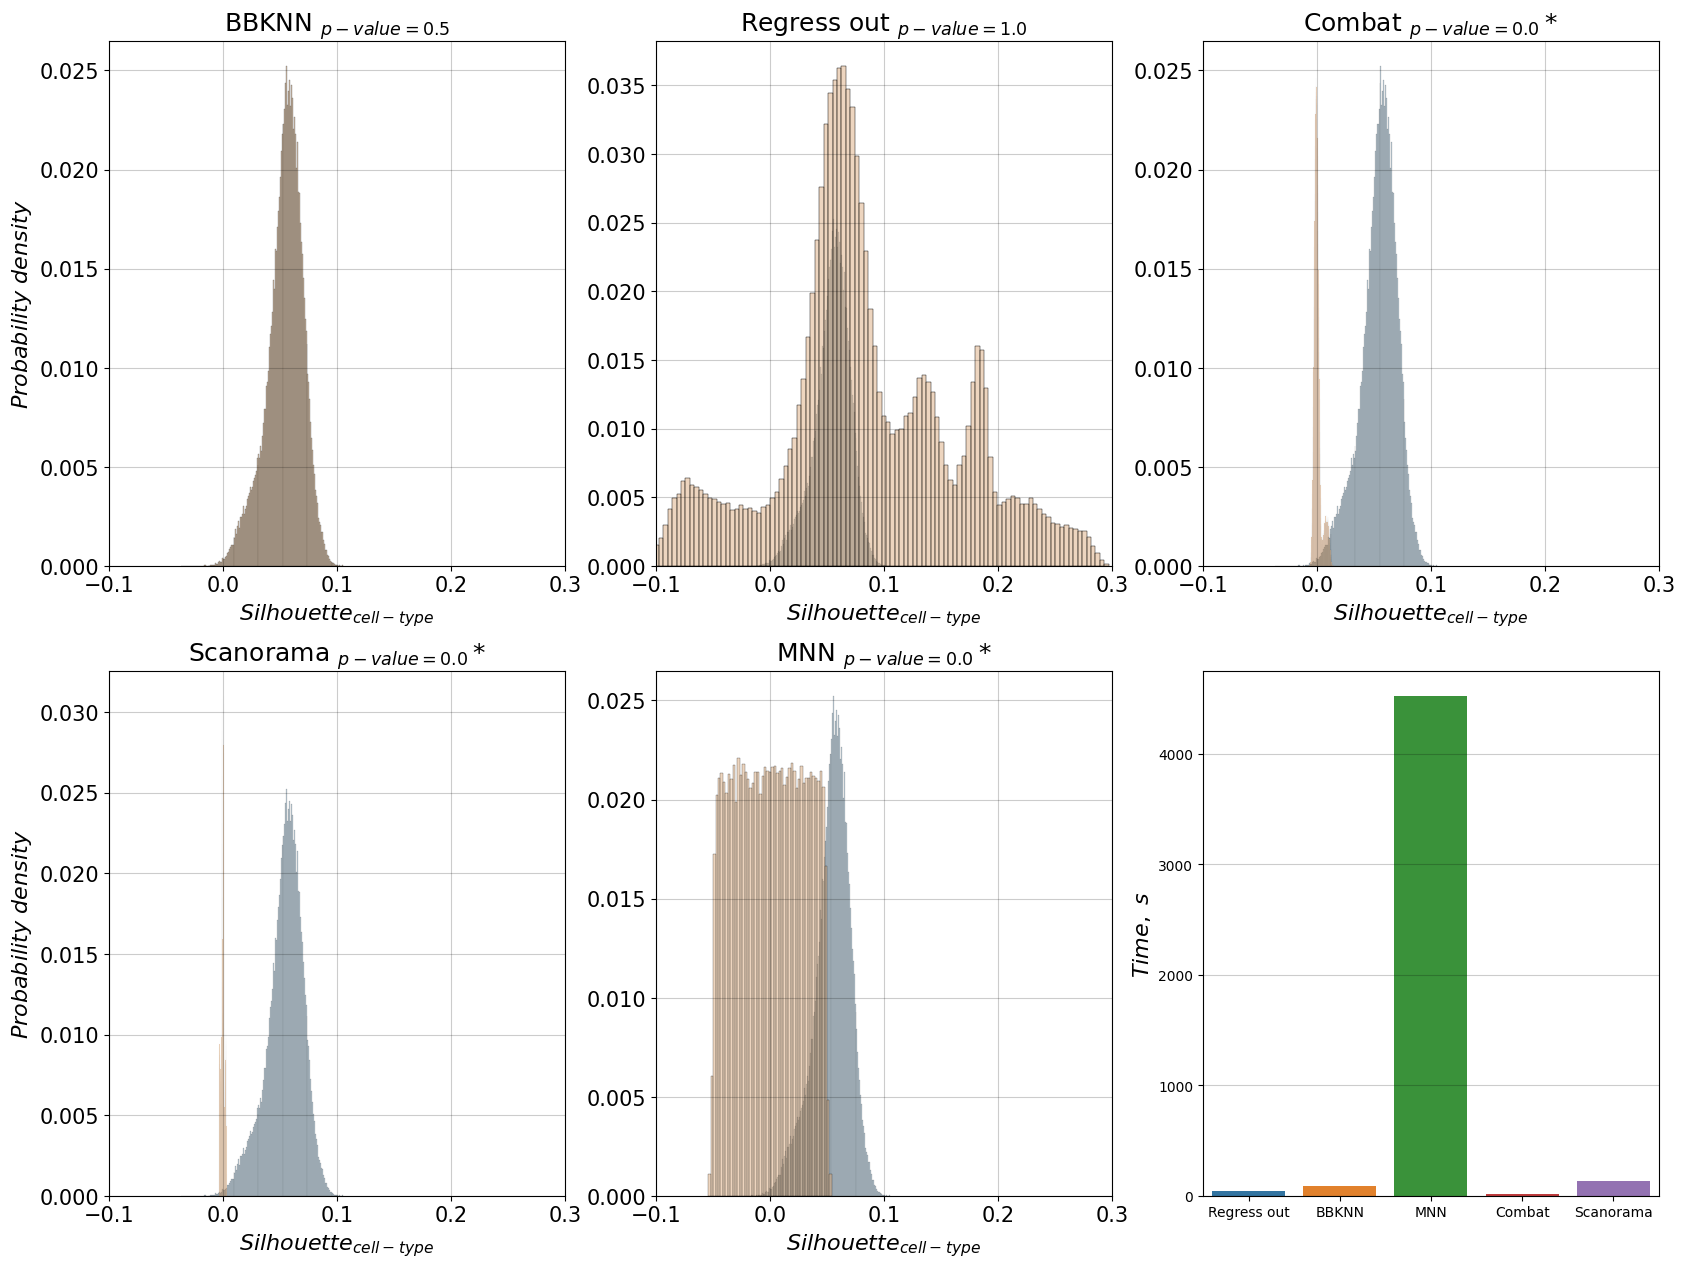

In [18]:
# Silhs based on batch
plot_result(sim_adata7_silhs, algs_title, calculate_p_val(sim_adata7_silhs, by="batch")["p-value"], time_table["simulated_80000"], by="batch", xlim=[-0.1, 0.3])